# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS para adicionar
- Eugenia Heatmap
- adicionar rate de compra de departments

Links datasets user and sample
sample: https://drive.google.com/file/d/1yWG47xO_8CLTdYIjo3k3007WxUgFpZjl/view?usp=sharing
total: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link
normal zip: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link

# File and libraries

In [124]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart User Behaviour Analysis"


## DSLabs

In [125]:
%run "scripts/dslabs_functions.py"

## data functions

In [126]:
%run "scripts/data_functions.py"

data_functions loaded


# Load

In [ ]:
# test_data=True
test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group    
    # sample=0.5
    # users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)

    # use case with the correct sample csv
    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample_plussample50.csv')





users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51552 entries, 15650 to 4706
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        51552 non-null  int64  
 1   total_orders                   51552 non-null  int64  
 2   mean_products                  51552 non-null  float64
 3   max_products                   51552 non-null  int64  
 4   std_num_products               51552 non-null  float64
 5   mean_lag_between_orders        51552 non-null  float64
 6   std_lag_between_orders         51552 non-null  float64
 7   mean_reorder_rate              51552 non-null  float64
 8   mean_weekend_order_rate        51552 non-null  float64
 9   mean_order_dow                 51552 non-null  float64
 10  top_order_dow                  51552 non-null  int64  
 11  order_dow_variety              51552 non-null  int64  
 12  top_order_hour                 51552 non-null  i

## variable type definition

In [128]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'mean_products', 'max_products', 'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order_rate', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'mean_peak_time_of_day_rate', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [129]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Drop outliers

In [130]:
variable_types: dict[str, list] = get_variable_types(users_df)

numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000
mean,15.569347,11.851092,17.674309,3.950858,15.467137,6.633997,0.432669,0.266048,2.747908,2.524694,4.691283,13.259214,7.197335,3.307528,0.732673,1.676345,2.839715
std,16.617467,6.654108,10.220697,2.562138,7.193615,3.250312,0.210955,0.216639,1.015179,2.146515,1.678592,3.995534,3.863462,1.480979,0.236797,1.740634,0.817271
min,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.570796,1.000000
25%,5.000000,7.064516,10.000000,2.101393,9.545455,4.279244,0.269231,0.098361,2.107143,1.000000,3.000000,10.000000,4.000000,2.295849,0.588235,1.570796,2.000000
50%,9.000000,10.821488,16.000000,3.457807,14.701305,7.051056,0.430108,0.237565,2.752115,2.000000,5.000000,13.000000,6.000000,3.172159,0.772727,1.570796,3.000000
75%,19.000000,15.466615,23.000000,5.225558,20.733857,9.047100,0.594151,0.388889,3.373855,5.000000,6.000000,16.000000,10.000000,4.161745,0.936553,3.141593,3.000000
max,99.000000,73.629032,100.000000,38.070288,30.000000,21.213203,0.978182,1.000000,6.000000,6.000000,7.000000,23.000000,24.000000,11.691878,1.000000,3.141593,4.000000


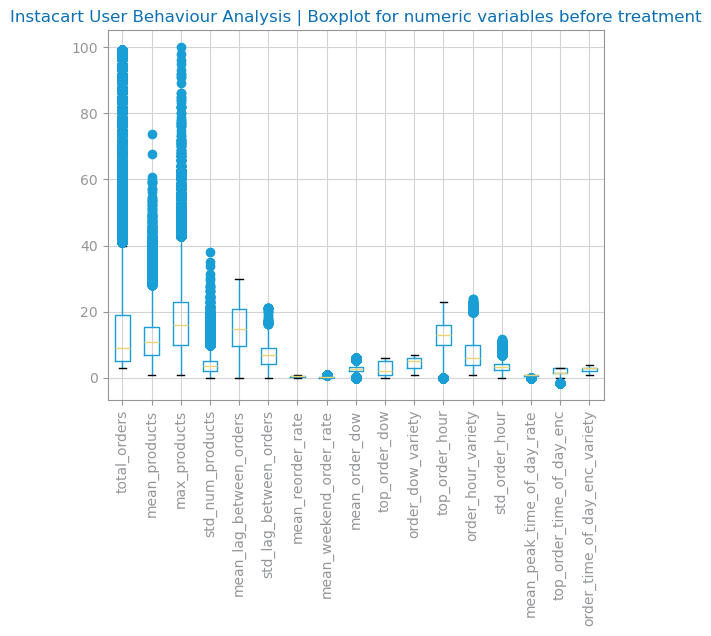

In [131]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

from matplotlib.pyplot import savefig, show, title


variables_types: dict[str, list] = get_variable_types(users_df)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    users_df[numeric].boxplot(rot=90)
    title(f'{file_tag} | Boxplot for numeric variables before treatment')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

In [132]:



def truncate_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df[var] = np.where(df[var] < lower_bound, lower_bound, df[var])
			df[var] = np.where(df[var] > upper_bound, upper_bound, df[var])
	return df



def drop_numeric_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df





main_outliers = ['total_orders', 'mean_products','std_order_hour','max_products','std_num_products']

users_df = truncate_outliers(users_df, summary5, main_outliers)

users_df = drop_numeric_outliers(users_df, summary5, main_outliers)


users_df=users_df[users_df['total_orders']<=40]


# users_df = drop_numeric_outliers(users_df, summary5, numeric_vars)

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000,51552.000000
mean,13.113302,11.337995,16.864755,3.708291,15.467137,6.633997,0.432669,0.266048,2.747908,2.524694,4.691283,13.259214,7.197335,3.238138,0.732673,1.676345,2.839715
std,9.871343,4.680100,7.231270,1.773208,7.193615,3.250312,0.210955,0.216639,1.015179,2.146515,1.678592,3.995534,3.863462,1.038614,0.236797,1.740634,0.817271
min,3.000000,5.196983,7.453613,1.388720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.826549,0.000000,-1.570796,1.000000
25%,5.000000,7.064516,10.000000,2.101393,9.545455,4.279244,0.269231,0.098361,2.107143,1.000000,3.000000,10.000000,4.000000,2.295849,0.588235,1.570796,2.000000
50%,9.000000,10.821488,16.000000,3.457807,14.701305,7.051056,0.430108,0.237565,2.752115,2.000000,5.000000,13.000000,6.000000,3.172159,0.772727,1.570796,3.000000
75%,19.000000,15.466615,23.000000,5.225558,20.733857,9.047100,0.594151,0.388889,3.373855,5.000000,6.000000,16.000000,10.000000,4.161745,0.936553,3.141593,3.000000
max,32.186815,18.505200,27.895006,6.512997,30.000000,21.213203,0.978182,1.000000,6.000000,6.000000,7.000000,23.000000,24.000000,4.788506,1.000000,3.141593,4.000000


### New Outlier visualization

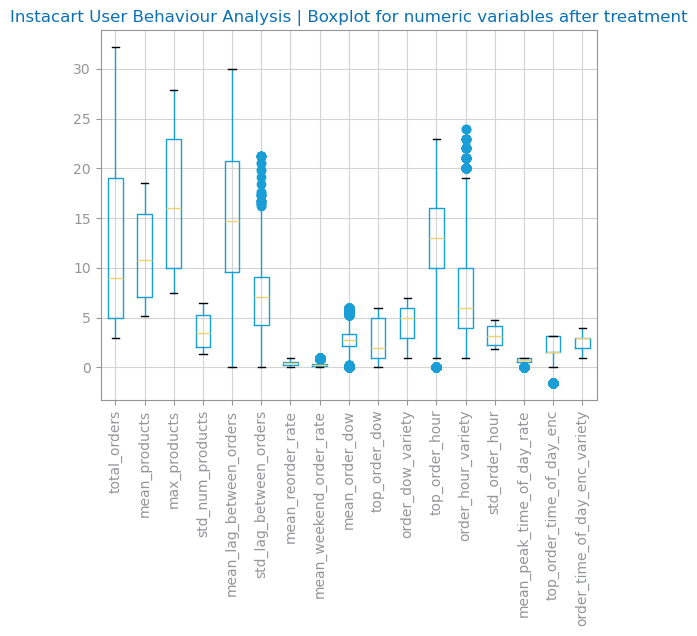

In [133]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots


if [] != numeric:
    users_df[numeric].boxplot(rot=90)
    title(f'{file_tag} | Boxplot for numeric variables after treatment')  # Correct way to set title
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

In [134]:
print(len(users_df))

51552


## User Order feature selection and scaling

In [135]:

from sklearn.preprocessing import StandardScaler, RobustScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Replace infinite values with NaN
reorder_numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
reorder_numeric_features.dropna(inplace=True)

# Normalize the data
scaler = RobustScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


# User Order KMEANS clustering

## User Order Elbow Method Studies

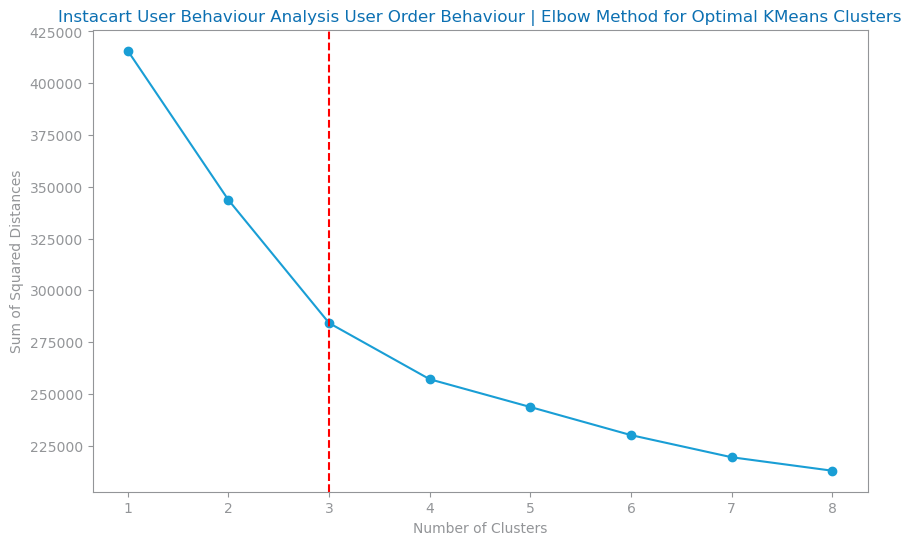

In [136]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 9))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

## User Order Sillhouete study for kmeans

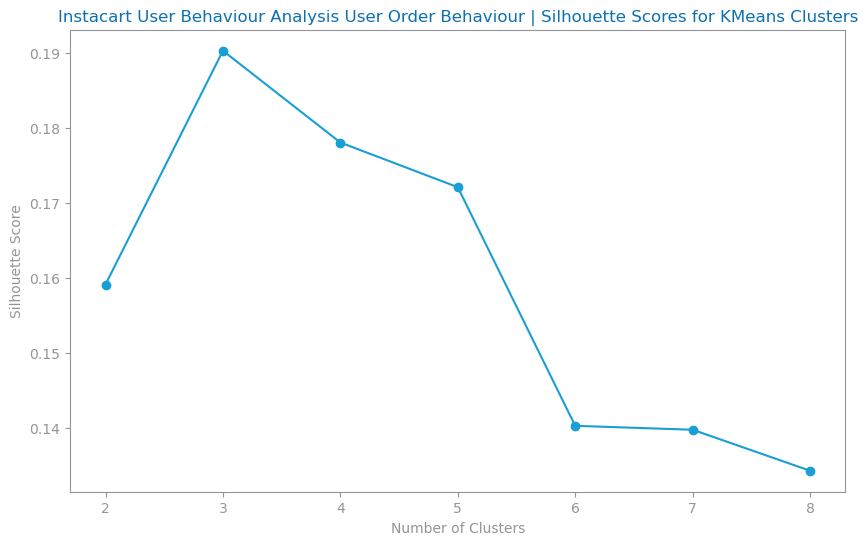

In [137]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 9))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reorder_numeric_features_scaled)
    silhouette_avg = silhouette_score(reorder_numeric_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## User Order Kmeans model

In [138]:
# Clustering
reorder_kmeans = KMeans(n_clusters=3, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
print(f'Silhouette Score for KMeans: {silhouette_kmeans}')

Silhouette Score for KMeans: 0.1903192601742928


## User Order Centroids

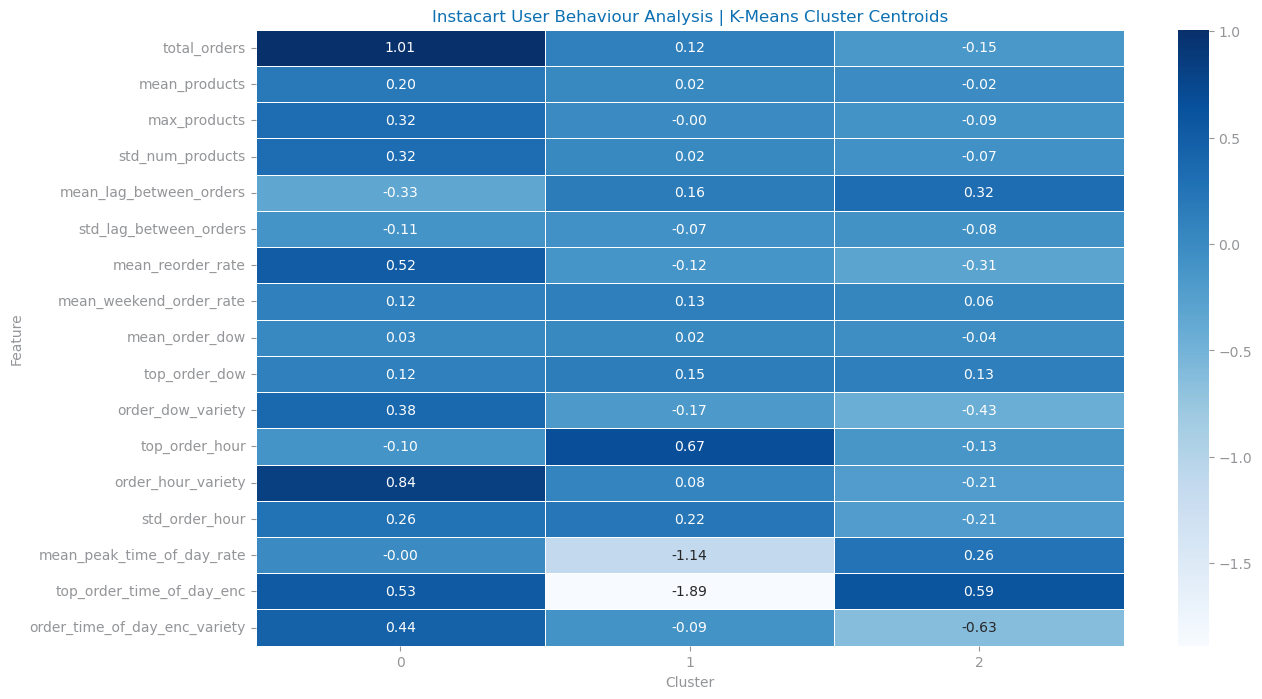

In [139]:
# Create a dataframe of centroids
centroids = pd.DataFrame(reorder_kmeans.cluster_centers_, columns=reorder_numeric_features.columns)

# Plot a heatmap of feature values for each cluster
plt.figure(figsize=(14, 8))
sns.heatmap(centroids.T, cmap="Blues", annot=True, fmt=".2f", linewidths=0.5)
plt.title(f"{file_tag} | K-Means Cluster Centroids")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()


# User Order Agglomerative

## User Order Sillouette Study for Agglomerative

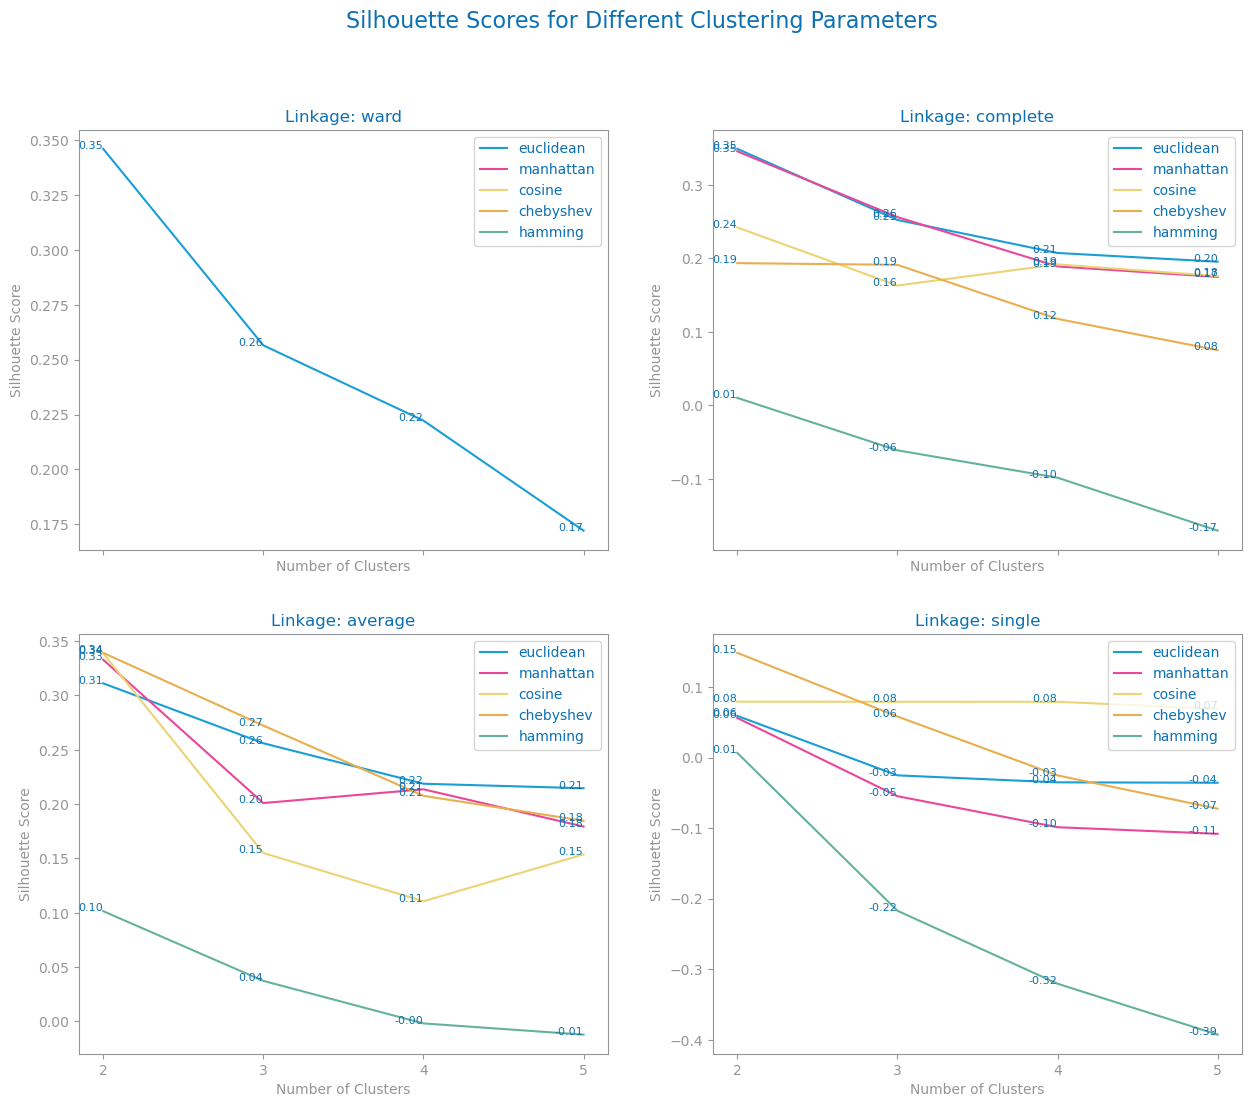

In [140]:
# Create a sample of the reorder_numeric features
reorder_numeric_features_sampled = reorder_numeric_features.sample(frac=0.2, random_state=42)

# Evaluate agglomerative clustering on the sampled data
evaluate_agglomerative_clustering(reorder_numeric_features_sampled, n_clusters_list=[2,3,4,5], scale='no')

## User Order Dendrogram

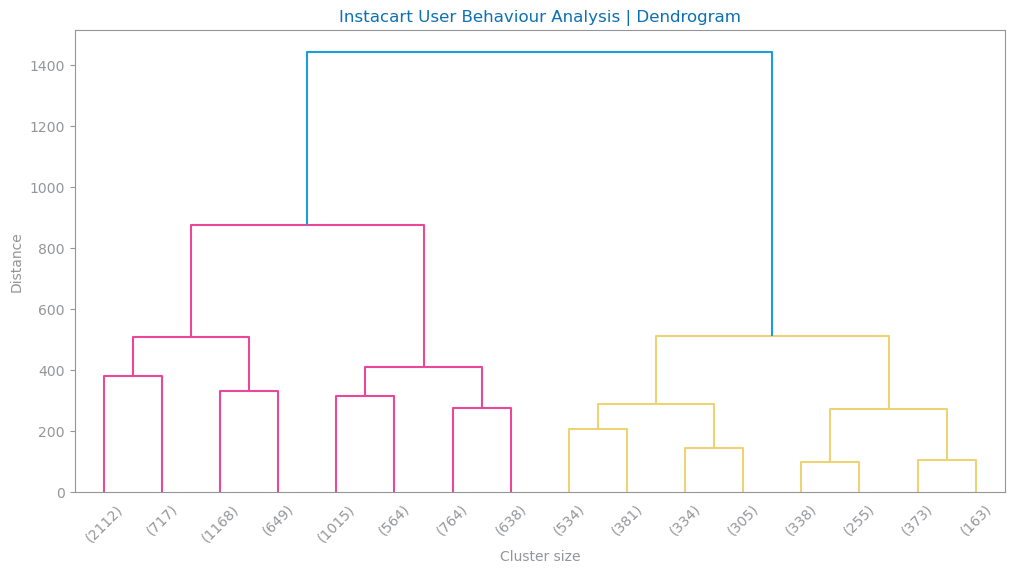

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_sampled, method='average', metric='chebyshev')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## User Order Agglomerative Model

In [172]:
reorder_agglo = AgglomerativeClustering(n_clusters=2, metric='chebyshev', linkage='average' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

reorder_y_pred_agglo

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

# Final User Order Model Evaluation

In [173]:

from sklearn.metrics import silhouette_score


# Intrinsic Evaluation
# silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.1903192601742928
Silhouette Score for Agglomerative Clustering: 0.2351483778712434


## User Order Cluster Labeling

In [174]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Map the cluster labels to custom names
cluster_mapping = {i: f'C{i+1}' for i in range(max(reorder_y_pred_kmeans.max(), reorder_y_pred_agglo.max()) + 1)}
users_df['kmeans_cluster'] = users_df['kmeans_cluster'].map(cluster_mapping)
users_df['agglo_cluster'] = users_df['agglo_cluster'].map(cluster_mapping)

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,mean_products,max_products,std_num_products,mean_lag_between_orders,std_lag_between_orders,mean_reorder_rate,mean_weekend_order_rate,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,mean_peak_time_of_day_rate,top_order_time_of_day_enc,order_time_of_day_enc_variety,kmeans_cluster,agglo_cluster
15650,18153,6.000000,5.272727,8.000000,2.374103,30.000000,0.000000,0.181818,0.000000,1.272727,0,2,14,5,2.435755,0.954545,3.141593,3,C3,C1
90393,116778,11.000000,8.148936,12.000000,4.298527,20.933333,6.890046,0.446809,0.000000,1.063830,0,4,16,7,2.989962,0.382979,-1.570796,3,C2,C2
21897,105077,10.000000,7.933333,11.000000,1.884025,17.593750,11.207592,0.120000,0.253333,2.653333,1,5,11,7,2.813865,0.906667,3.141593,3,C3,C1
61775,117510,9.000000,5.196983,7.453613,1.779513,13.666667,11.293435,0.216216,0.216216,2.189189,0,4,17,6,2.076611,0.513514,3.141593,2,C3,C1
82515,75609,32.186815,14.107517,24.000000,4.910712,4.535373,2.932117,0.740247,0.339676,3.261656,5,7,15,18,3.963242,0.699334,3.141593,4,C1,C1


### User Order Cluster Counts

In [183]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()
kmeans_cluster_share = (kmeans_cluster_counts / len(users_df)) * 100

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()
agglo_cluster_share = (agglo_cluster_counts / len(users_df)) * 100

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)
print("\nKMeans Cluster Share (%):")
print(kmeans_cluster_share)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)
print("\nAgglomerative Clustering Share (%):")
print(agglo_cluster_share)

KMeans Cluster Counts:
kmeans_cluster
C1    17395
C2    10522
C3    23635
dtype: int64

KMeans Cluster Share (%):
kmeans_cluster
C1    33.742629
C2    20.410459
C3    45.846912
dtype: float64

Agglomerative Clustering Counts:
agglo_cluster
C1    40637
C2    10915
dtype: int64

Agglomerative Clustering Share (%):
agglo_cluster
C1    78.827204
C2    21.172796
dtype: float64


### User Order cluster boxplots

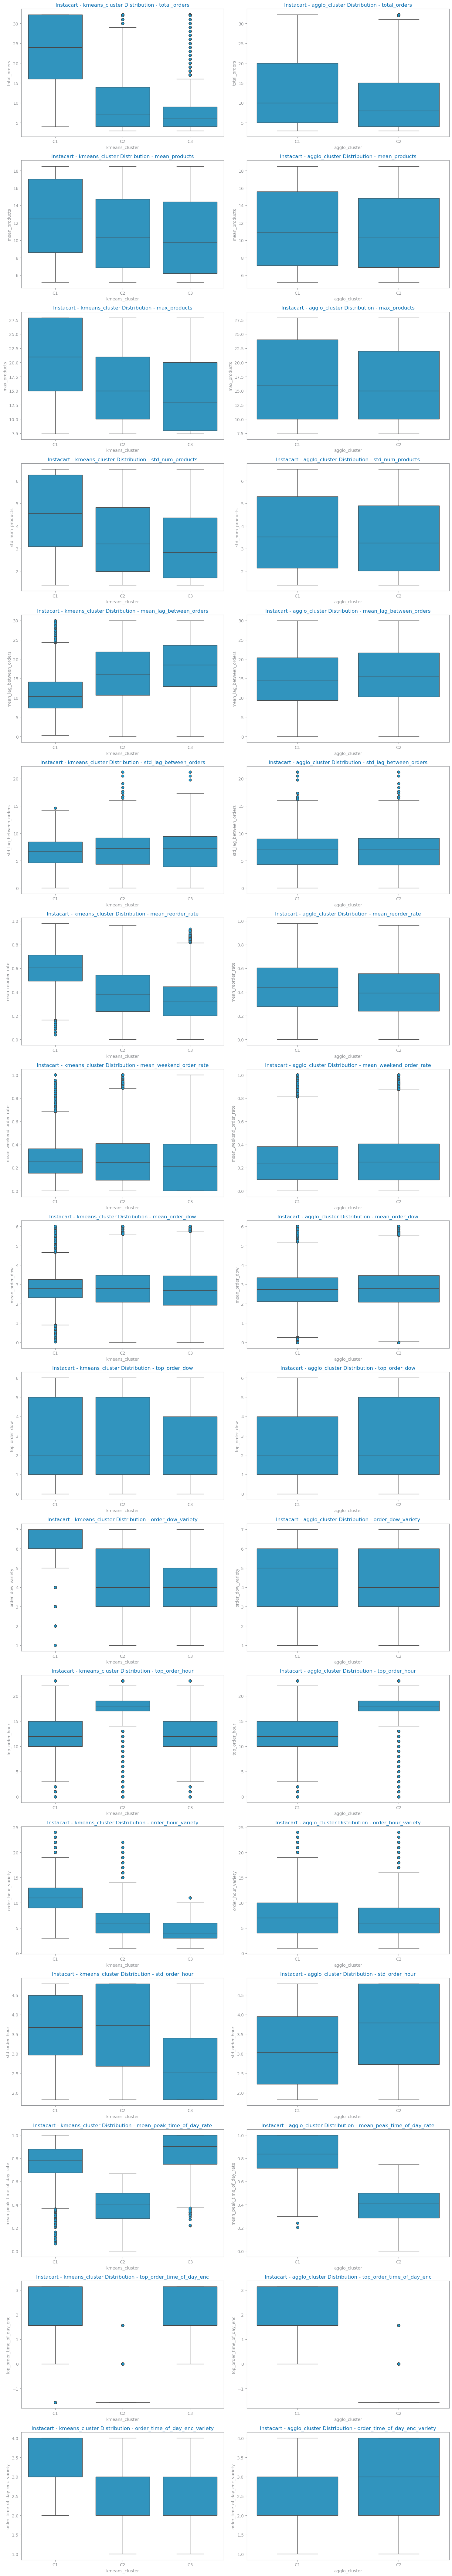

In [182]:
# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels,file_tag='Instacart')

# User Order PCA Visualization

## User Order PCA Dataframe

In [177]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.716117,-1.020527,-1.283969,-0.800197,-0.001313,1.124854
1,-0.330050,2.113929,-1.983192,-0.268570,0.032658,-0.059802
2,-0.674310,-0.971238,0.036528,-0.705406,-1.152197,-0.192016
3,-1.268931,-0.419344,-0.443560,-0.846857,-0.738290,-1.331120
4,3.037951,-0.777323,0.596554,-0.016337,0.530007,0.039091


## User Order pca explained variance ratio

In [178]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_

# Sum of explained variance ratio
total_explained_variance = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total explained variance by all components: {total_explained_variance}')


Explained variance ratio: [0.2453961  0.1984057  0.15451769 0.09711904 0.06803067 0.05228066]
Total explained variance by all components: 0.8157498657066785


## User Order pca plot

### 2D PCA Plot

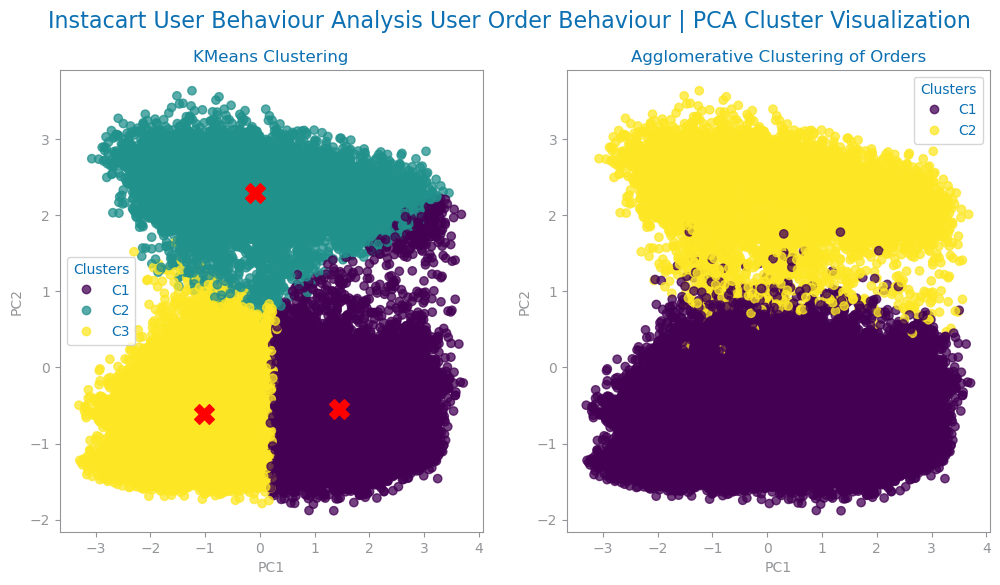

In [179]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
scatter_kmeans = plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.75)
kmeans_centroids = pca_reorder.transform(reorder_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering')
handles, labels = scatter_kmeans.legend_elements()
labels = [f'C{i+1}' for i in range(len(labels))]
plt.legend(handles, labels, title="Clusters")

# Agglomerative Clustering
plt.subplot(122)
scatter_agglo = plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.75)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')
handles, labels = scatter_agglo.legend_elements()
labels = [f'C{i+1}' for i in range(len(labels))]
plt.legend(handles, labels, title="Clusters")

plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

### PCA Plot 3D

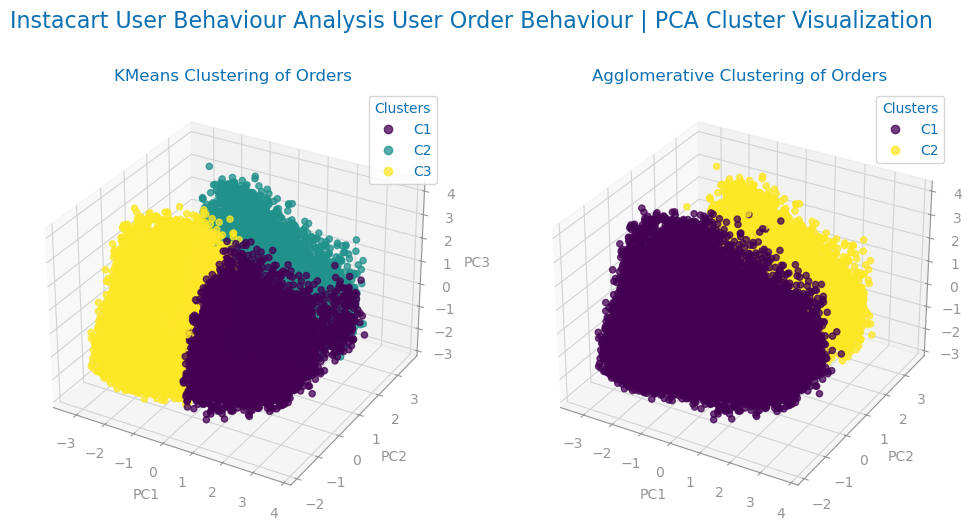

In [180]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
scatter_kmeans = ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.75)
kmeans_centroids_3d = pca_reorder.transform(reorder_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering of Orders')
handles, labels = scatter_kmeans.legend_elements()
labels = [f'C{i+1}' for i in range(len(labels))]
ax.legend(handles, labels, title="Clusters")

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
scatter_agglo = ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.75)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')
handles, labels = scatter_agglo.legend_elements()
labels = [f'C{i+1}' for i in range(len(labels))]
ax.legend(handles, labels, title="Clusters")

fig.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# Cluster Profiling

## load instacart data and enrich

In [188]:
# Create a dataframe with only user_id and cluster columns
user_clusters_df = users_df[['user_id', 'kmeans_cluster', 'agglo_cluster']]

# Load the instacart_pre_proc_sample.csv file
instacart_sample_df = pd.read_csv('data/instacart_pre_proc_sample.csv')

# Join the dataframes on user_id
merged_df = pd.merge(instacart_sample_df, user_clusters_df, on='user_id', how='inner')


merged_df=enrich_instacart_df(merged_df)

# Display the merged dataframe
merged_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_time_of_day,...,order_dow_cos,num_products,reorder_rate,kmeans_cluster,agglo_cluster,product_name,aisle_id,department_id,aisle,department
0,43,20915,1,0,39630,14,5,17,4.0,Evening,...,0.5,7,0.285714,C3,C1,Mozzarella Light Low Moisture Part Skim String...,21,16,packaged cheese,dairy eggs
1,43,21949,2,0,39630,14,5,17,4.0,Evening,...,0.5,7,0.285714,C3,C1,White Cheddar Semisoft Cheese,21,16,packaged cheese,dairy eggs
2,43,8817,3,0,39630,14,5,17,4.0,Evening,...,0.5,7,0.285714,C3,C1,13 Gallon Kitchen Drawstring Trash Bags,60,17,trash bags liners,household
3,43,37867,4,1,39630,14,5,17,4.0,Evening,...,0.5,7,0.285714,C3,C1,Classic Variety Pack Donuts,61,19,cookies cakes,snacks
4,43,12850,5,0,39630,14,5,17,4.0,Evening,...,0.5,7,0.285714,C3,C1,Original Denture Adhesive Cream,20,11,oral hygiene,personal care


## instacart profiling kmeans

In [206]:
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display

# List of columns to group by
groupby_cols = ['order_time_of_day', 'product_name', 'aisle', 'department', 'reordered', 'is_weekend', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order']

# Dictionary to store the resulting dataframes
grouped_dataframes = {}

count_col = 'order_id'
cluster_col = 'kmeans_cluster'

# Loop through the list of columns and perform groupby and aggregation
for col in groupby_cols:
    # Group by the column and kmeans_cluster, then count unique order_ids
    grouped_df = merged_df.groupby([col, cluster_col])[count_col].nunique().unstack(fill_value=0)
    # Rename the columns to include the cluster_col name
    grouped_df.columns = [f'{cluster_col}_{cluster}' for cluster in grouped_df.columns]
    
    # Calculate the percentage share for each cluster
    for cluster in grouped_df.columns:
        grouped_df[f'{cluster} share'] = (grouped_df[cluster] / grouped_df[cluster].sum() * 100).round(2)
    
    # Add rank for each cluster share
    for cluster in grouped_df.columns:
        if ' share' in cluster:
            grouped_df[f'{cluster} rank'] = grouped_df[cluster].rank(ascending=False, method='min').astype(int)
    
    # Calculate the total for each row
    grouped_df['Total'] = grouped_df[[col for col in grouped_df.columns if ' share' not in col and ' rank' not in col]].sum(axis=1)
    
    # Drop the total columns per cluster, keeping only the share, rank, and total columns
    grouped_df = grouped_df.loc[:, grouped_df.columns.str.contains('share|rank|Total')]
    # Sort by the Total column in descending order
    grouped_df = grouped_df.sort_values(by='Total', ascending=False)
    # Sort by the first cluster share column
    grouped_df = grouped_df.sort_values(by=grouped_df.columns[0], ascending=False)
    
    grouped_dataframes[col] = grouped_df

# Display the resulting dataframes as HTML tables
for col, df in grouped_dataframes.items():
    display(HTML(f"<h3> {file_tag} | {count_col} count | Grouped by {col} per {cluster_col} </h3>"))
    display(df.head(20))

,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
order_time_of_day,,,,,,,
Afternoon,41.23,27.04,48.19,1,2,1,32296
Morning,36.16,16.64,37.56,2,3,2,26703
Evening,18.09,48.16,12.42,3,1,3,17213
Night,4.52,8.15,1.83,4,4,4,3621


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
product_name,,,,,,,
Banana,1.48,1.46,1.41,1,1,1,11799
Bag of Organic Bananas,1.25,1.11,0.95,2,2,2,9489
Organic Strawberries,0.88,0.69,0.64,3,4,4,6531
Organic Baby Spinach,0.79,0.75,0.72,4,3,3,6208
Organic Hass Avocado,0.73,0.55,0.49,5,6,7,5331
Organic Avocado,0.55,0.56,0.54,6,5,5,4427
Organic Whole Milk,0.48,0.36,0.32,7,11,10,3500
Organic Raspberries,0.47,0.37,0.29,8,10,13,3440
Limes,0.45,0.38,0.41,9,9,9,3463


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
aisle,,,,,,,
fresh fruits,7.84,7.46,7.25,1,1,1,44472
fresh vegetables,6.23,6.26,5.86,2,2,2,35746
packaged vegetables fruits,5.15,5.02,4.81,3,3,3,29393
yogurt,3.71,3.70,3.16,4,4,4,20913
milk,3.55,3.13,2.83,5,5,6,19439
packaged cheese,3.19,3.02,3.04,6,6,5,18170
water seltzer sparkling water,2.56,2.69,2.74,7,7,7,15157
soy lactosefree,2.38,2.32,2.19,8,8,10,13550
chips pretzels,2.26,2.31,2.48,9,9,8,13380


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
department,,,,,,,
produce,16.05,15.51,15.47,1,1,1,59951
dairy eggs,14.43,14.16,13.67,2,2,2,53844
beverages,9.39,9.76,9.84,3,3,3,36035
snacks,9.18,8.84,9.30,4,4,4,34596
frozen,7.60,8.33,7.84,5,5,5,29305
pantry,7.28,7.18,7.49,6,6,6,27603
bakery,5.82,5.64,5.59,7,7,7,21741
deli,5.11,5.12,4.84,8,8,8,19121
canned goods,4.52,4.43,4.68,9,9,9,17156


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
reordered,,,,,,,
1,55.51,50.97,45.99,1,1,2,70273
0,44.49,49.03,54.01,2,2,1,62448


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
is_weekend,,,,,,,
0,73.56,72.42,75.94,1,1,1,58968
1,26.44,27.58,24.06,2,2,2,20865


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
order_number,,,,,,,
6,3.41,5.09,8.08,1,7,6,3681
9,3.41,3.89,3.71,1,9,9,2828
5,3.39,6.34,9.59,3,5,5,4064
8,3.38,3.99,4.94,4,8,8,3024
1,3.35,8.28,14.18,5,3,3,5018
7,3.32,5.18,6.17,6,6,7,3335
3,3.30,8.87,15.18,7,1,1,5230
4,3.27,7.18,11.88,8,4,4,4475
2,3.24,8.83,14.62,9,2,2,5103


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
order_dow,,,,,,,
1,17.35,15.22,18.35,1,2,1,13751
0,16.90,19.53,17.52,2,1,2,13914
2,13.73,12.80,14.52,3,4,3,10974
5,13.59,12.73,11.76,4,5,7,10447
6,12.85,14.86,12.30,5,3,6,10418
4,12.82,12.24,12.40,6,7,5,10099
3,12.76,12.62,13.14,7,6,4,10230


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
order_hour_of_day,,,,,,,
10,8.81,4.28,10.41,1,12,1,6737
11,8.70,4.48,9.98,2,10,2,6632
15,8.51,5.68,9.95,3,6,4,6677
14,8.40,4.91,9.67,4,8,6,6485
13,8.34,5.04,9.97,5,7,3,6519
9,8.17,3.55,8.56,6,13,8,6019
12,8.00,4.30,9.86,7,11,5,6235
16,7.97,7.10,8.73,8,5,7,6380
8,5.93,2.46,5.45,9,15,9,4230


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
days_since_prior_order,,,,,,,
7.0,10.94,8.67,7.85,1,2,2,7502
6.0,8.70,7.09,4.45,2,3,4,5744
3.0,8.55,5.23,2.37,3,7,15,5169
4.0,8.46,6.03,2.83,4,5,9,5277
5.0,8.35,6.04,3.11,5,4,7,5266
2.0,7.77,5.09,2.09,6,8,16,4729
8.0,6.13,5.31,4.33,7,6,5,4245
1.0,5.56,3.44,1.79,8,10,19,3401
30.0,4.67,13.84,27.19,9,1,1,7632


,kmeans_cluster_C1 share,kmeans_cluster_C2 share,kmeans_cluster_C3 share,kmeans_cluster_C1 share rank,kmeans_cluster_C2 share rank,kmeans_cluster_C3 share rank,Total
weeks_since_prior_order,,,,,,,
1.0,49.64,40.67,28.32,1,1,2,33186
0.0,24.37,15.45,7.77,2,4,5,14938
2.0,14.01,17.34,18.88,3,3,3,11527
4.0,6.72,17.68,33.61,4,2,1,9972
3.0,5.26,8.86,11.43,5,5,4,5192


# outputs
